### Turing.ml example: https://turing.ml/dev/tutorials/10-bayesian-differential-equations/ 

In [ ]:
using Turing, Distributions, DifferentialEquations

# Import MCMCChain, Plots, and StatsPlots for visualizations and diagnostics.
using MCMCChains, Plots, StatsPlots

# Set a seed for reproducibility.
using Random
Random.seed!(14);

In [ ]:
function lotka_volterra(du,u,p,t)
    x, y = u
    α, β, γ, δ  = p
    du[1] = (α - β*y)x # dx =
    du[2] = (δ*x - γ)y # dy =
end
p = [1.5, 1.0, 3.0, 1.0]
u0 = [1.0,1.0]
prob1 = ODEProblem(lotka_volterra,u0,(0.0,10.0),p)
sol = solve(prob1,Tsit5())
plot(sol)

sol1 = solve(prob1,Tsit5(),saveat=0.1)
odedata = Array(sol1) + 0.8 * randn(size(Array(sol1)))
plot(sol1, alpha = 0.3, legend = false); scatter!(sol1.t, odedata')

In [ ]:
Turing.setadbackend(:forwarddiff)

@model function fitlv(data, prob1)
    σ ~ InverseGamma(2, 3) # ~ is the tilde character
    α ~ truncated(Normal(1.5,0.5),0.5,2.5)
    β ~ truncated(Normal(1.2,0.5),0,2)
    γ ~ truncated(Normal(3.0,0.5),1,4)
    δ ~ truncated(Normal(1.0,0.5),0,2)

    p = [α,β,γ,δ]
    prob = remake(prob1, p=p)
    predicted = solve(prob,Tsit5(),saveat=0.1)

    for i = 1:length(predicted)
        data[:,i] ~ MvNormal(predicted[i], σ)
    end
end

model = fitlv(odedata, prob1)

# This next command runs 3 independent chains without using multithreading.
chain = mapreduce(c -> sample(model, NUTS(.65),1000), chainscat, 1:3)
plot(chain)

In [ ]:
pl = scatter(sol1.t, odedata');
chain_array = Array(chain)
for k in 1:300
    resol = solve(remake(prob1,p=chain_array[rand(1:1500), 1:4]),Tsit5(),saveat=0.1)
    plot!(resol, alpha=0.1, color = "#BBBBBB", legend = false)
end
# display(pl)
plot!(sol1, w=1, legend = false)

# troubleshooting transporter model



In [34]:
using Catalyst, DifferentialEquations, StatsPlots, Plots, DataFrames, CSV, Random, Turing, Latexify, ModelingToolkit, DynamicHMC
using ModelingToolkit: varmap_to_vars
using Optim, Noise, AdvancedMH, MCMCChains, StatsBase, Sundials
using BenchmarkTools

function gen_∂logπ∂θ(vi, spl, model)
    function ∂logπ∂θ(x)
        return Turing.Core.gradient_logp(x, vi, model, spl)
    end
    return ∂logπ∂θ
end

function test_gradient(model)
    var_info = Turing.VarInfo(model)
    ctx = Turing.DefaultContext()

    spl = DynamicPPL.Sampler(NUTS(.65))
    DynamicPPL.link!(var_info, spl)

    ∂logπ∂θ = gen_∂logπ∂θ(var_info, spl, model)
    return ∂logπ∂θ, var_info[spl]
end


# Normal log-likelihood calculation
function calc_norm_log_likelihood(mu,sigma,X)
    # Normal log-likelihood function: -[(n/2)ln(2pp*sigma^2)]-[sum((X-mu)^2)/(2*sigma^2)]
    # ref: https://www.statlect.com/fundamentals-of-statistics/normal-distribution-maximum-likelihood 
    n = length(X)
    f1 = -1*(n/2)*log(2*pi*sigma^2)
    f2_a = -1/(2*sigma^2)
    f2_b = 0 
    for i in 1:n
        f2_b += (X[i]-mu[i])^2
    end
    f2 = f2_a*f2_b
    log_likelihood = f1+f2
end

# flux calculation function
function calc_flux(p,u,v)
    flux_in = v*(p[1]*u[1])
    flux_out = v*(p[2]*u[2].*u[3])
    net_flux = flux_in - flux_out         
end

Random.seed!(14)
sigma_f = 1
t_short = false

# define reaction network in Catalyst
rn = @reaction_network begin
  (k1_f*H_out, k1_r), OF <--> OF_Hb
  (k2_f, k2_r), OF_Hb <--> IF_Hb
  (k3_f, k3_r), IF_Hb + S_in <--> IF_Hb_Sb
  (k4_f, k4_r), IF_Hb_Sb <--> IF_Sb + H_in
  (k5_f, k5_r), IF_Sb <--> OF_Sb
  (k6_f, k6_r*S_out), OF_Sb <--> OF
end H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r

# convert reaction network to ODEsystem
odesys = convert(ODESystem, rn)

# define initial variable values and parameters
H_out_ref = 1e-7
S_out_ref = 1e-3
stdev_ref = sigma_f*1e-13
@parameters  H_out S_out k1_f k1_r k2_f k2_r k3_f k3_r k4_f k4_r k5_f k5_r k6_f k6_r stdev_s
@variables t H_in(t) S_in(t) OF(t) OF_Hb(t) IF_Hb(t) IF_Hb_Sb(t) IF_Sb(t) OF_Sb(t)
u0map = [H_in => 1e-7, S_in => 1e-3, 
        OF => 2.833e-8, OF_Hb => 2.833e-8,  
        IF_Hb => 2.833e-8, IF_Hb_Sb => 2.833e-8,
        IF_Sb => 2.125e-8, OF_Sb => 2.125e-8, 
        ]
pmap = [H_out => H_out_ref, S_out => S_out_ref,
        k1_f =>1e10, k1_r =>1e3,
        k2_f =>1e2, k2_r =>1e2,
        k3_f =>1e7, k3_r =>1e3,
        k4_f =>1e3, k4_r =>1e10,
        k5_f =>1e2, k5_r =>1e2,
        k6_f =>1e3, k6_r =>1e7
        ]

# create ODEproblem w/ timed events discrete callback
if t_short == true
    t_sample = 0.4
else
    t_sample = 0.04
end    
tspan1 = (0.0,15)
oprob = ODEProblem(odesys, u0map, tspan1, pmap)
event_times = [5.0,10.0]
condition(u,t,integrator) = t ∈ event_times
function affect!(integrator)
    if integrator.t == 5.0
        integrator.p[1] = 5e-8
    elseif integrator.t == 10.0
        integrator.p[1] = 1e-7
    end
end
cb = DiscreteCallback(condition,save_positions=(false, false), affect!)

atol=1e-12
rtol=1e-9

# get y_true and y_obs
# s_true = solve(oprob, CVODE_BDF(), abstol = 1e-18, reltol = 1e-12, saveat=t_sample, callback=cb, tstops=event_times)
s_true = solve(oprob, TRBDF2(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times)
@btime solve(oprob,TRBDF2(),abstol = atol,  reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob,RadauIIA5(),abstol = atol,  reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob, KenCarp4(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 
@btime solve(oprob,CVODE_BDF(), abstol = atol, reltol = rtol, saveat=t_sample, callback=cb, tstops=event_times) 


k_true = [pmap[9][2], pmap[10][2]]
c_true = [s_true[IF_Hb_Sb], s_true[H_in], s_true[IF_Sb]]
vol = 0.0001
y_true = calc_flux(k_true,c_true,vol)


# y_obs = add_gauss(y_true,stdev_ref)
# df = DataFrame(data = y_obs)
# CSV.write("data_grid_test3.csv", df)
df2 = CSV.read("data_grid_test3.csv", DataFrame)
y_obs = df2[!, "data"]

ref_log_likelihood = calc_norm_log_likelihood(y_obs,stdev_ref,y_true)

println(length(y_obs))
println(ref_log_likelihood)


##### sampling
println("sampling...")
# create Turing model w/ forward differentiation
Turing.setadbackend(:forwarddiff)
@model function rxn_sampler(data, prob, sys)
    
    
    log_stdev_sample2 ~ Uniform(log10(5e-14), log10(5e-13))
    
    log_k1_f ~ Uniform(6,12) # log10 rate constant (ref=1e10)
    log_k1_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3)  
    
    log_k2_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k2_r ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    
    log_k3_f ~ Uniform(3,9)  # log10 rate constant (ref=1e7) 
    log_k3_r ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    
    log_k4_f ~ Uniform(-1,5)  # log10 rate constant (ref=1e3) 
    log_k4_r ~ Uniform(6,12)  # log10 rate constant (ref=1e10)
    
    log_k5_f ~ Uniform(-2,4)  # log10 rate constant (ref=1e2)
    log_k5_r ~ Uniform(-2,4)   # log10 rate constant (ref=1e2)
    
    log_k6_f ~ Uniform(-1,5)  # log10  rate constant (ref=1e3)
    
    # set parameter values and initial concentrations
    log_k6_r = (log_k1_f+log_k2_f+log_k3_f+log_k4_f+log_k5_f+log_k6_f)-(log_k1_r+log_k2_r+log_k3_r+log_k4_r+log_k5_r) 
    pmap2 = [H_out => H_out_ref, S_out => S_out_ref,
            k1_f =>10.0^log_k1_f, k1_r =>10.0^log_k1_r,
            k2_f =>10.0^log_k2_f, k2_r =>10.0^log_k2_r,
            k3_f =>10.0^log_k3_f, k3_r =>10.0^log_k3_r,
            k4_f =>10.0^log_k4_f, k4_r =>10.0^log_k4_r,
            k5_f =>10.0^log_k5_f, k5_r =>10.0^log_k5_r,
            k6_f =>10.0^log_k6_f, k6_r =>10.0^log_k6_r,
    ]
    
    # solve ODE system
    pnew2 = varmap_to_vars(pmap2, parameters(sys))
    oprob2 = remake(prob, p=pnew2)
    #sol2 = solve(oprob2, TRBDF2(), abstol = 1e-18, reltol = 1e-12, saveat=0.04, callback=cb, tstops=event_times)
    sol2 = solve(oprob2, TRBDF2(), abstol = atol, reltol = rtol, saveat=0.04, callback=cb, tstops=event_times)
    
    # calc flux (y_pred)
    k2 = [pmap2[9][2], pmap2[10][2]]
    c2 = [sol2[IF_Hb_Sb], sol2[H_in], sol2[IF_Sb]]
    vol = 0.0001
    y_pred2 = calc_flux(k2,c2,vol)
    
    for i = 1:length(data)
        data[i] ~ Normal(y_pred2[i], 10^log_stdev_sample2)
    end
end

model = rxn_sampler(y_obs, oprob, odesys)

#model = fit(...)
∇, vi = test_gradient(model);
∇(vi)


# # Use NelderMead
# mle_estimate1 = optimize(model, MLE(), NelderMead(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use SimulatedAnnealing
# mle_estimate2 = optimize(model, MLE(), SimulatedAnnealing(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use ParticleSwarm
# mle_estimate3 = optimize(model, MLE(), ParticleSwarm(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# # Use Newton
# #mle_estimate4 = optimize(model, MLE(), Newton())

# # Use AcceleratedGradientDescent
# mle_estimate5 = optimize(model, MLE(), AcceleratedGradientDescent(), Optim.Options(iterations = 10_000, allow_f_increases=true, g_tol=atol))

# println(mle_estimate1.values.array)
# println(mle_estimate2.values.array)
# println(mle_estimate3.values.array)
# #println(mle_estimate4.values.array)
# println(mle_estimate5.values.array)

  387.921 μs (1574 allocations: 104.08 KiB)
  395.271 μs (704 allocations: 98.55 KiB)
  521.428 μs (752 allocations: 90.88 KiB)
  862.557 μs (4972 allocations: 178.78 KiB)
376
10722.29183539798
sampling...


(-2.315034515752e6, [1.5889625935781347e6, 0.2718989894572027, -0.26351944310991016, -1.1125179015699154, 25.37038371933078, -46.74077883763402, 14.6978249977829, 7623.85466493062, -28201.57254762211, -0.6936265139153567, 0.772594994502652, 0.10542509980324943])

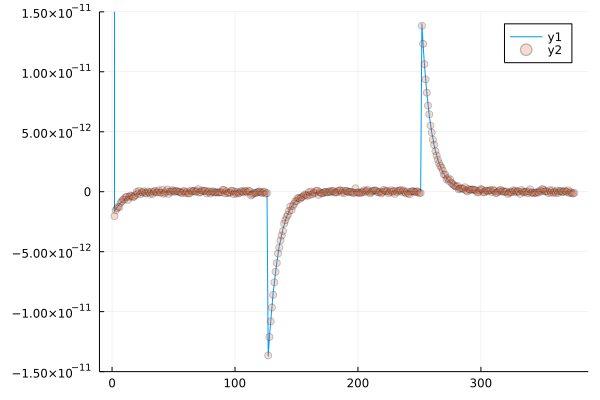

In [35]:
plot(y_true, ylim=(-1.5e-11, 1.5e-11));scatter!(y_obs, alpha=0.25)

In [ ]:
iter=10_000_000

# Use NelderMead
mle_estimate1 = optimize(model, MLE(), NelderMead(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

# # Use SimulatedAnnealing
# mle_estimate2 = optimize(model, MLE(), SimulatedAnnealing(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

# # Use ParticleSwarm
# mle_estimate3 = optimize(model, MLE(), ParticleSwarm(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

# # Use Newton
# #mle_estimate4 = optimize(model, MLE(), Newton())

# # Use AcceleratedGradientDescent
# mle_estimate5 = optimize(model, MLE(), AcceleratedGradientDescent(), Optim.Options(iterations = iter, allow_f_increases=true, g_tol=atol))

println(mle_estimate1.values.array)
# println(mle_estimate2.values.array)
# println(mle_estimate3.values.array)
# #println(mle_estimate4.values.array)
# println(mle_estimate5.values.array)

### Single cycle transporter ODEs

#### sampling

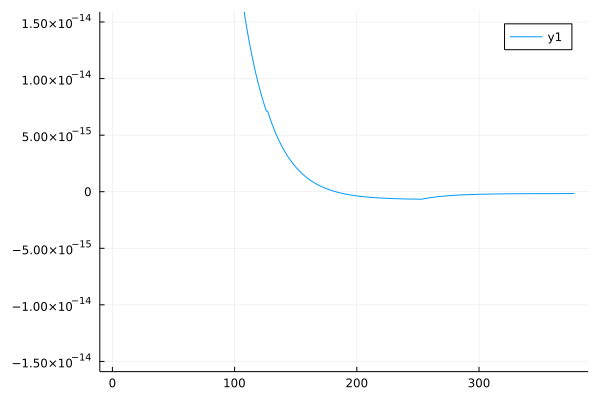